In [1]:
import sys

sys.path.append('/home/max/myrepos/vlstm_cuda/')

import torch
torch.set_printoptions(linewidth=200, threshold=100000)
import triton
import triton.language as tl
import math

In [2]:
triton.runtime.driver.active.get_current_target()

GPUTarget(backend='cuda', arch=89, warp_size=32)

In [3]:
from src_triton.mlstm_parallel_fw_v0.mlstm import mlstm_fw
from src_triton.mlstm_parallel_fw_v0.torch_impl import vlstm_fw_torch_ref as mlstm_fw_torch
from src_triton.utils import lower_triangular_block_matrix
from plot_utils import plot_numerical_diffs_single

In [4]:
list(range(0,0*8,4))

[]

In [5]:
S = 256 #32 #32 #16 #8 # seq len
B = 1 # batch size
NH = 1 # num heads
DH = 128 # dim per head
DTYPE = torch.float32
DEVICE = torch.device("cuda:0")

In [6]:
# create qkv, inputgates, forgetgates 
torch.manual_seed(0) #TODO from here: with seed=0 even the pytorch version alone breaks for float16 and bfloat16
# fixed:
# qs = torch.arange((B*NH*S*DH), device=DEVICE, dtype=DTYPE).reshape((B, NH, S, DH)) / 10.
# qs = torch.ones((B, NH, S, DH), device=DEVICE, dtype=DTYPE) / 100.
# ks = torch.ones((B, NH, S, DH), device=DEVICE, dtype=DTYPE) / 100.
# # vs = torch.ones((B, NH, S, DH), device=DEVICE, dtype=DTYPE) / 100.
# vs = torch.arange((B*NH*S*DH), device=DEVICE, dtype=DTYPE).reshape((B, NH, S, DH)) / 100.
# # vs = torch.zeros((B, NH, S, DH), device=DEVICE, dtype=DTYPE)
# vs[:,:,1,0] = 7.
# qs[:,:,1,0] = 1.

# vs[:,:,1,16] = 8.
# qs[:,:,1,16] = 1.
# random: 
qs = torch.randn((B, NH, S, DH), device=DEVICE, dtype=DTYPE)
ks = torch.randn((B, NH, S, DH), device=DEVICE, dtype=DTYPE)
vs = torch.randn((B, NH, S, DH), device=DEVICE, dtype=DTYPE)
# igs = (1. + torch.arange((B * NH * S), device=DEVICE, dtype=DTYPE)).reshape(B, NH, S) / 10.
# igs = torch.zeros((B, NH, S), device=DEVICE, dtype=DTYPE) #/ 10.
igs = torch.randn((B, NH, S), device=DEVICE, dtype=DTYPE) #/ 10.
# fgs = torch.ones((B, NH, S), device=DEVICE, dtype=DTYPE)
fgs = torch.randn((B, NH, S), device=DEVICE, dtype=DTYPE)

dHs = torch.randn((B, NH, S, DH), device=DEVICE, dtype=DTYPE)

In [7]:
# inputs float16
dtype_fp16 = torch.float16
qs_half = qs.to(dtype=dtype_fp16)
ks_half = ks.to(dtype=dtype_fp16)
vs_half = vs.to(dtype=dtype_fp16)
igs_half = igs.to(dtype=dtype_fp16)
fgs_half = fgs.to(dtype=dtype_fp16)
dHs_half = dHs.to(dtype=dtype_fp16)

In [8]:
# inputs bfloat16
dtype_bf16 = torch.bfloat16
qs_bf16 = qs.to(dtype=dtype_bf16)
ks_bf16 = ks.to(dtype=dtype_bf16)
vs_bf16 = vs.to(dtype=dtype_bf16)
igs_bf16 = igs.to(dtype=dtype_bf16)
fgs_bf16 = fgs.to(dtype=dtype_bf16)
dHs_bf16 = dHs.to(dtype=dtype_bf16)

### compare errors pure pytorch

In [9]:
hs_pt, n_pt, m_pt, _, matLogD_pt, matD_pt, matC_pt = mlstm_fw_torch(queries=qs, keys=ks, values=vs, igate_preact=igs.unsqueeze(-1), fgate_preact=fgs.unsqueeze(-1))

In [10]:
hs_pt_half, n_pt_half, m_pt_half, _, matLogD_pt_half, matD_pt_half, matC_pt_half = mlstm_fw_torch(queries=qs_half, keys=ks_half, values=vs_half, igate_preact=igs_half.unsqueeze(-1), fgate_preact=fgs_half.unsqueeze(-1))

In [11]:
hs_pt_bf16, n_pt_bf16, m_pt_bf16, _, matLogD_pt_bf16, matD_pt_bf16, matC_pt_bf16 = mlstm_fw_torch(queries=qs_bf16, keys=ks_bf16, values=vs_bf16, igate_preact=igs_bf16.unsqueeze(-1), fgate_preact=fgs_bf16.unsqueeze(-1))

In [12]:
FW_RTOL = 1e-10
FW_ATOL = 1e-4
BW_RTOL = FW_ATOL
BW_ATOL = FW_ATOL
print(f"====== Full -> Half ======")
print(f"fw hs match: {torch.allclose(hs_pt_half.float(), hs_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(hs_pt_half - hs_pt))}")
print(f"fw n match: {torch.allclose(n_pt_half.float(), n_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(n_pt_half - n_pt))}")
print(f"fw m match: {torch.allclose(m_pt_half.float(), m_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(m_pt_half - m_pt))}")
print(f"fw D match: {torch.allclose((matD_pt_half.float() - matD_pt).tril(), torch.zeros_like((matD_pt)), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max((matD_pt_half.float() - matD_pt).tril())}")

print(f"====== Full -> bfloat16 ======")
print(f"fw hs match: {torch.allclose(hs_pt_bf16.float(), hs_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(hs_pt_bf16 - hs_pt))}")
print(f"fw n match: {torch.allclose(n_pt_bf16.float(), n_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(n_pt_bf16 - n_pt))}")
print(f"fw m match: {torch.allclose(m_pt_bf16.float(), m_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(m_pt_bf16 - m_pt))}")
print(f"fw D match: {torch.allclose((matD_pt_bf16.float() - matD_pt).tril(), torch.zeros_like((matD_pt)), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max((matD_pt_bf16.float() - matD_pt).tril())}")


====== Full -> Half ======
fw hs match: False, max diff: 0.45120811462402344
fw n match: False, max diff: 0.4326951503753662
fw m match: False, max diff: 0.1912614107131958
fw D match: False, max diff: 0.15697169303894043
====== Full -> bfloat16 ======
fw hs match: False, max diff: 2.818922519683838
fw n match: False, max diff: 0.9333474636077881
fw m match: False, max diff: 0.9422379732131958
fw D match: False, max diff: 0.5769522190093994


In [13]:
hs_half, m_half, n_half = mlstm_fw(matQ=qs_half, matK=ks_half, matV=vs_half, vecI=igs_half, vecF=fgs_half)

In [14]:
hs_half[:, :, :10, :10]

tensor([[[[ 2.5449e+00, -7.1631e-01, -4.9341e-01,  1.2671e-01,  1.0138e-01, -4.0356e-01,  9.0234e-01,  8.1006e-01, -6.8848e-01,  1.3721e-01],
          [ 2.9297e+00, -9.9854e-01, -7.0215e-01, -1.5137e-01, -2.7588e-01, -3.9087e-01,  9.5020e-01,  1.4814e+00, -5.6738e-01, -1.6956e-01],
          [ 3.5339e-02, -1.0382e-01, -1.3110e-01, -3.2745e-02, -3.3545e-01, -4.1229e-02,  1.3196e-01,  5.6934e-01,  3.6255e-01, -2.5659e-01],
          [-9.5068e-01, -2.2734e+00,  4.9512e-01, -1.1396e+00,  1.4929e-01,  1.2793e+00, -1.6272e-01, -1.5371e+00, -1.6846e+00, -1.3428e+00],
          [ 8.2764e-01, -8.9648e-01, -6.7920e-01, -7.6855e-01,  5.0000e-01,  6.8311e-01,  5.8154e-01,  1.1084e-01, -5.4883e-01, -1.2441e+00],
          [-1.0098e+00,  5.9375e-01, -1.0244e+00,  3.9180e+00, -3.9844e-01,  5.7568e-01, -8.5498e-01,  5.1849e-02, -2.0059e+00, -1.5107e+00],
          [-2.9761e-01,  4.0015e-01, -8.5889e-01,  1.6797e-01,  1.9690e-01, -2.4109e-01, -3.0518e-02,  3.2568e-04,  4.1748e-01, -2.7515e-01],
      

In [15]:
hs_diff = hs_half - hs_pt_half

In [16]:
hs_diff[:, :, -10:, :10], hs_diff.abs().max()

(tensor([[[[-2.4414e-04,  0.0000e+00,  2.4414e-04, -4.8828e-04,  1.8311e-04,  6.1035e-05, -2.4414e-04,  6.1035e-05, -4.8828e-04,  9.7656e-04],
           [ 9.7656e-04, -4.8828e-04,  0.0000e+00,  7.3242e-04, -4.8828e-04,  0.0000e+00,  4.8828e-04,  1.2207e-04,  7.3242e-04, -9.7656e-04],
           [-2.4414e-04,  1.2207e-04,  0.0000e+00,  0.0000e+00,  2.4796e-05,  0.0000e+00,  0.0000e+00, -3.0518e-05,  0.0000e+00,  0.0000e+00],
           [ 0.0000e+00,  0.0000e+00, -8.0109e-05,  0.0000e+00,  0.0000e+00, -9.7656e-04,  0.0000e+00,  6.1035e-05,  0.0000e+00, -4.8828e-04],
           [ 3.0518e-04,  0.0000e+00,  2.4414e-04,  0.0000e+00,  0.0000e+00, -2.4414e-04,  0.0000e+00,  0.0000e+00,  3.6621e-04, -2.4414e-04],
           [-2.4414e-04, -6.1035e-05, -2.4414e-04, -4.8828e-04, -2.4414e-04,  2.4414e-04,  4.8828e-04, -9.7656e-04,  0.0000e+00,  4.8828e-04],
           [ 1.2207e-04,  4.5776e-05,  1.8311e-04,  2.4414e-04, -3.0518e-05, -2.4414e-04,  2.4414e-04,  3.0518e-05,  2.4414e-04, -2.4414e-04],

In [17]:
FW_RTOL = 1e-10
FW_ATOL = 1e-4
BW_RTOL = FW_ATOL
BW_ATOL = FW_ATOL
print(f"====== Full -> Half ======")
print(f"fw hs match: {torch.allclose(hs_half.float(), hs_pt_half.float(), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(hs_half - hs_pt_half))}")
print(f"fw n match: {torch.allclose(n_half.float(), n_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(n_half.unsqueeze(-1) - n_pt_half))}")
print(f"fw m match: {torch.allclose(m_half.float(), m_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(m_half.unsqueeze(-1) - m_pt_half))}")


====== Full -> Half ======
fw hs match: False, max diff: 0.009765625
fw n match: False, max diff: 0.0017864704132080078
fw m match: False, max diff: 0.0003662109375


In [18]:
n_half.unsqueeze(-1).shape, n_pt_half.shape

(torch.Size([1, 1, 256, 1]), torch.Size([1, 1, 256, 1]))

In [19]:
n_half, m_half

(tensor([[[0.9948, 1.5829, 1.6886, 1.4204, 1.4394, 0.5427, 0.8487, 2.0514, 1.1405, 1.2823, 2.1813, 0.8598, 1.4639, 0.8656, 0.5461, 0.8075, 0.7931, 0.6875, 1.7486, 0.8217, 0.9174, 0.7281, 1.0440,
           1.2649, 1.9287, 0.5337, 1.7775, 0.9846, 1.2400, 1.1996, 1.2589, 0.5054, 1.2228, 0.7652, 0.9378, 0.6227, 0.5995, 4.9414, 1.7731, 1.3654, 1.1780, 1.8647, 0.5544, 2.4847, 4.0647, 0.8900,
           2.8283, 3.5199, 0.3650, 0.3241, 0.4687, 1.5090, 0.2085, 1.5643, 0.7492, 0.9008, 1.2313, 2.4005, 1.3993, 0.5569, 0.0788, 1.2506, 0.3967, 0.2280, 1.2826, 1.3697, 2.8111, 3.6390, 0.8570,
           0.9153, 1.6064, 1.3536, 0.8154, 2.3104, 2.3355, 0.8020, 1.2746, 0.2619, 0.6397, 0.3658, 0.8021, 0.4915, 0.2927, 1.5601, 0.5681, 0.4959, 0.6150, 0.8305, 0.7908, 0.3895, 1.8664, 1.4750,
           1.1938, 1.2086, 0.3288, 0.3041, 0.6602, 0.3017, 0.6447, 1.9675, 1.6348, 1.1613, 0.3545, 0.3340, 1.4061, 1.7745, 0.5185, 0.5620, 1.0359, 0.1839, 0.5666, 0.9192, 0.4935, 0.4356, 2.2107,
           0.7725, 1.4660

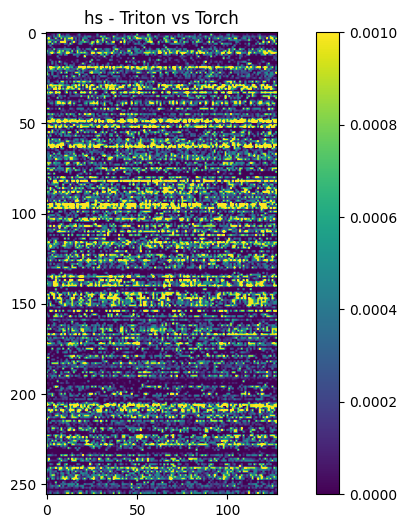

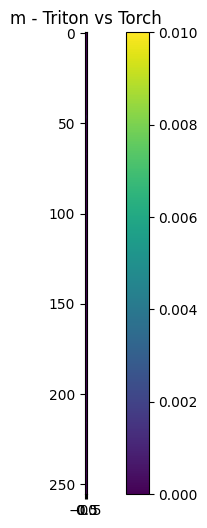

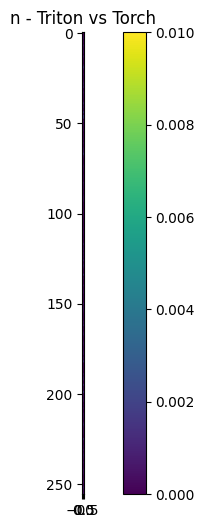

In [20]:
vmax = 0.001
fig = plot_numerical_diffs_single(hs_half, hs_pt_half, "hs - Triton vs Torch", vmax=vmax)

fig = plot_numerical_diffs_single(m_half.unsqueeze(-1), m_pt_half, "m - Triton vs Torch", vmax=0.01)

fig = plot_numerical_diffs_single(n_half.unsqueeze(-1), n_pt_half, "n - Triton vs Torch", vmax=0.01)

In [21]:
igs_half.stride(0), igs_half.stride(1), igs_half.stride(2)

(256, 256, 1)

In [22]:
bool(3 & 2)

True

In [23]:
torch.ones(4)[:, None]

tensor([[1.],
        [1.],
        [1.],
        [1.]])

## Measure Performance

In [24]:
warmup = 100
rep = 1000

BATCH, H, HEAD_DIM = 2, 8, 128
N_CTX = 1024
dtype = torch.float16
device = torch.device("cuda:0")
q = torch.randn(
    (BATCH, H, N_CTX, HEAD_DIM), dtype=dtype, device=device, requires_grad=True
)
k = torch.randn(
    (BATCH, H, N_CTX, HEAD_DIM), dtype=dtype, device=device, requires_grad=True
)
v = torch.randn(
    (BATCH, H, N_CTX, HEAD_DIM), dtype=dtype, device=device, requires_grad=True
)
ig = torch.randn((BATCH, H, N_CTX), dtype=dtype, device=device, requires_grad=True)
fg = torch.randn((BATCH, H, N_CTX), dtype=dtype, device=device, requires_grad=True)

In [25]:
mlstm_pt = mlstm_fw_torch
fn = lambda: mlstm_pt(q, k, v, ig.unsqueeze(-1), fg.unsqueeze(-1))
ms = triton.testing.do_bench(fn, warmup=warmup, rep=rep)
ms

3.826223373413086

In [26]:
mlstm_pt_compile = torch.compile(mlstm_fw_torch)
fn = lambda: mlstm_pt_compile(q, k, v, ig.unsqueeze(-1), fg.unsqueeze(-1))
ms = triton.testing.do_bench(fn, warmup=warmup, rep=rep)
ms

1.383891224861145

In [27]:
mlstm_triton = mlstm_fw
fn = lambda: mlstm_triton(q, k, v, ig, fg)
ms = triton.testing.do_bench(fn, warmup=warmup, rep=rep)
ms

0.5681418776512146